<a href="https://colab.research.google.com/github/bondpy202212/AI_projects/blob/main/3_CV_with_Real_world_Images(horse_or_human).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [ ]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import zipfile

from google.colab import files
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array

**Download the training and validation sets**\
https://www.kaggle.com/datasets/sanikamal/horses-or-humans-dataset/data \
Horses or Humans is a dataset of 300×300 images, created by Laurence Moroney, that is licensed CC-By-2.0 for anybody to use in learning or testing computer vision algorithms.

In [ ]:
!kaggle datasets download -d sanikamal/horses-or-humans-dataset

Dataset URL: https://www.kaggle.com/datasets/sanikamal/horses-or-humans-dataset
License(s): other
100% 307M/307M [00:04<00:00, 87.7MB/s]
100% 307M/307M [00:04<00:00, 69.3MB/s]


**Unzip the sets**

In [ ]:
!unzip -q horses-or-humans-dataset.zip

**Define the directories containing the images**

In [ ]:
# Directory with training horse pictures
train_horse_dir = os.path.join('./horse-or-human/train/horses')

# Directory with training human pictures
train_human_dir = os.path.join('./horse-or-human/train/humans')

# Directory with validation horse pictures
validation_horse_dir = os.path.join('./horse-or-human/validation/horses')

# Directory with validation human pictures
validation_human_dir = os.path.join('./horse-or-human/validation/humans')

**Explore the data**


In [ ]:
#Check that the directories are not empty and that the train set has more images than the validation set
train_horse_names = os.listdir(train_horse_dir)
print(f'TRAIN SET HORSES: {train_horse_names[:10]}')

train_human_names = os.listdir(train_human_dir)
print(f'TRAIN SET HUMANS: {train_human_names[:10]}\n')

validation_horse_hames = os.listdir(validation_horse_dir)
print(f'VAL SET HORSES: {validation_horse_hames[:10]}')

validation_human_names = os.listdir(validation_human_dir)
print(f'VAL SET HUMANS: {validation_human_names[:10]}\n')

print(f'total training horse images: {len(os.listdir(train_horse_dir))}')
print(f'total training human images: {len(os.listdir(train_human_dir))}\n')

print(f'total validation horse images: {len(os.listdir(validation_horse_dir))}')
print(f'total validation human images: {len(os.listdir(validation_human_dir))}')

TRAIN SET HORSES: ['horse20-0.png', 'horse31-5.png', 'horse27-7.png', 'horse40-3.png', 'horse15-3.png', 'horse45-2.png', 'horse43-7.png', 'horse01-2.png', 'horse40-1.png', 'horse24-7.png']
TRAIN SET HUMANS: ['human08-12.png', 'human01-21.png', 'human17-16.png', 'human17-21.png', 'human07-13.png', 'human13-16.png', 'human02-27.png', 'human01-25.png', 'human13-23.png', 'human13-15.png']

VAL SET HORSES: ['horse4-503.png', 'horse4-043.png', 'horse3-141.png', 'horse2-441.png', 'horse3-326.png', 'horse5-103.png', 'horse4-588.png', 'horse3-416.png', 'horse1-204.png', 'horse4-072.png']
VAL SET HUMANS: ['valhuman05-18.png', 'valhuman02-01.png', 'valhuman03-08.png', 'valhuman02-14.png', 'valhuman03-01.png', 'valhuman05-13.png', 'valhuman05-07.png', 'valhuman01-07.png', 'valhuman05-12.png', 'valhuman02-12.png']

total training horse images: 500
total training human images: 527

total validation horse images: 128
total validation human images: 128


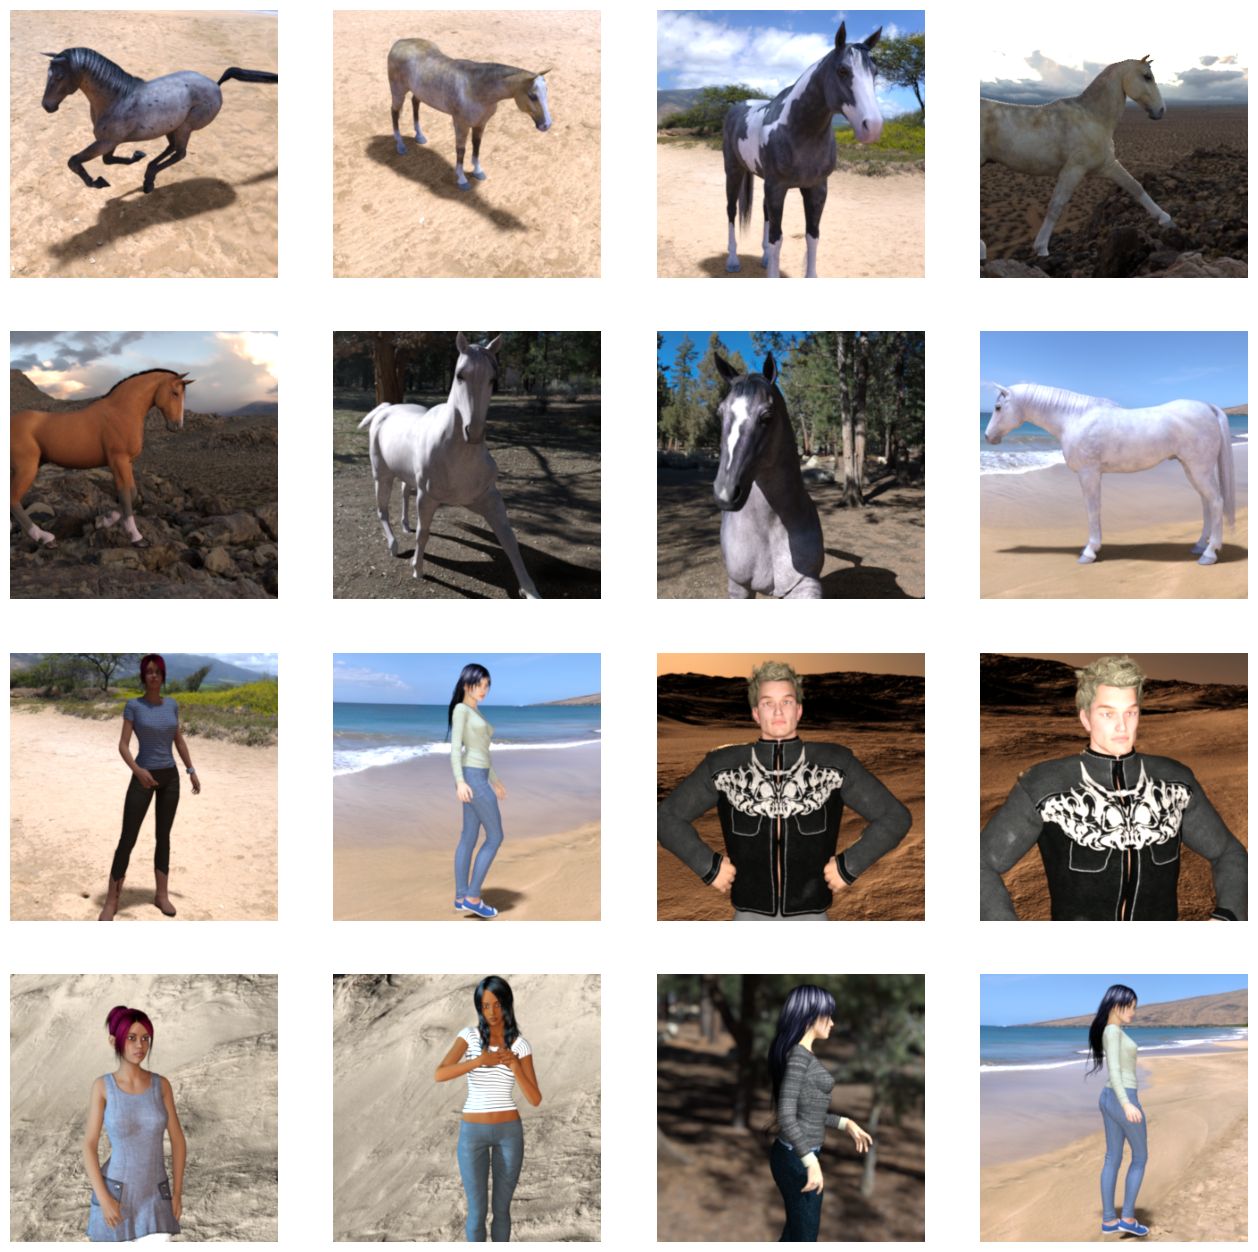

In [ ]:
# Now take a look at a few pictures to get a better sense of what they look like.
%matplotlib inline

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Now, display a batch of 8 horse and 8 human pictures.
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname)
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname)
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

**Defining the callback**

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.99:
            print("\nReached 99.0% accuracy so cancelling training!")
            self.model.stop_training = True

**Pre-processing the data**

In [ ]:
def image_generator():
  # All images will be rescaled by 1./255
  train_datagen = ImageDataGenerator(rescale=1/255)
  validation_datagen = ImageDataGenerator(rescale=1/255)

  # Flow training images in batches of 128 using train_datagen generator
  train_generator = train_datagen.flow_from_directory(
          './horse-or-human/train/',  # This is the source directory for training images
          target_size=(150, 150),  # All images will be resized to 150x150
          batch_size=128,
          # Since you used binary_crossentropy loss, you need binary labels
          class_mode='binary')

  # Flow training images in batches of 128 using train_datagen generator
  validation_generator = validation_datagen.flow_from_directory(
          './horse-or-human/validation/',  # This is the source directory for training imageses
          target_size=(150, 150),  # All images will be resized to 150x150
          batch_size=32,
          # Since you used binary_crossentropy loss, you need binary labels
          class_mode='binary')

  return train_generator, validation_generator

In [ ]:
# Save your generators in a variable
gen_train, gen_valid = image_generator()

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


**Creating and training model**

In [ ]:
def train_horse_human_model(train_generator, validation_generator):

  # Instantiate the callback
  callbacks = myCallback()

  # Define the model
  model = tf.keras.models.Sequential([
    # The image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.Input(shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Model resume printing
  model.summary()

  # Compile the model
  model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])


  # # Train the model
  history = model.fit(
      train_generator,
      epochs=20,
      verbose=1,
      validation_data = validation_generator,
      callbacks=[callbacks])

  return history, model


**Train the model**

In [ ]:
hist, model  = train_horse_human_model(gen_train, gen_valid)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18496)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       9,470,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,494,561 (36.22 MB)

 Trainable params: 9,494,561 (36.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 683ms/step - accuracy: 0.5491 - loss: 1.5474 - val_accuracy: 0.7539 - val_loss: 0.6571
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.7504 - loss: 0.7000 - val_accuracy: 0.8203 - val_loss: 0.6203
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 266ms/step - accuracy: 0.8209 - loss: 0.5849 - val_accuracy: 0.8633 - val_loss: 0.3703
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 297ms/step - accuracy: 0.8713 - loss: 0.3507 - val_accuracy: 0.5703 - val_loss: 2.5000
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step - accuracy: 0.8034 - loss: 0.4510 - val_accuracy: 0.8320 - val_loss: 0.8377
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - accuracy: 0.9653 - loss: 0.1051 - val_accuracy: 0.8398 - val_loss: 1.2467
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step - accuracy: 0.9198 - loss: 0.1965 - val_accuracy: 0.5273 - val_loss: 2.3559
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step - accuracy: 0.8220 - loss: 0.3963 - val_accuracy: 0.8906 - val_lo

**Model Prediction**

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(150, 150))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + '\n-- is a human --')
  else:
    print(fn + '\n-- is a horse --')

Saving crown-8818017_640.jpg to crown-8818017_640.jpg
Saving horse-197199_640.jpg to horse-197199_640.jpg
Saving horse-1201143_640.jpg to horse-1201143_640.jpg
Saving woman-8883626_640.jpg to woman-8883626_640.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
[0.9998914]
crown-8818017_640.jpg
-- is a human --
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[0.00421264]
horse-197199_640.jpg
-- is a horse --
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[0.0004946]
horse-1201143_640.jpg
-- is a horse --
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[0.99966824]
woman-8883626_640.jpg
-- is a human --


**Visualizing Intermediate Representations**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


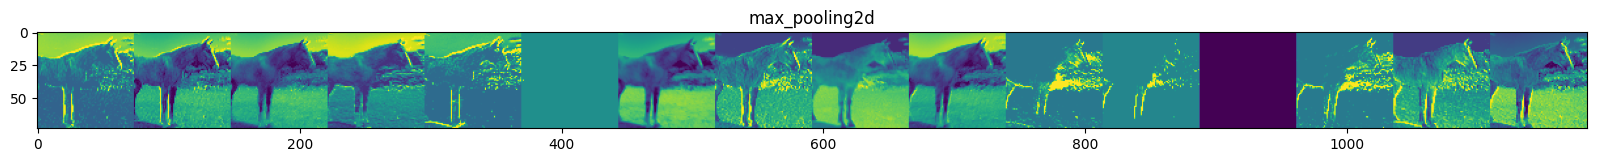

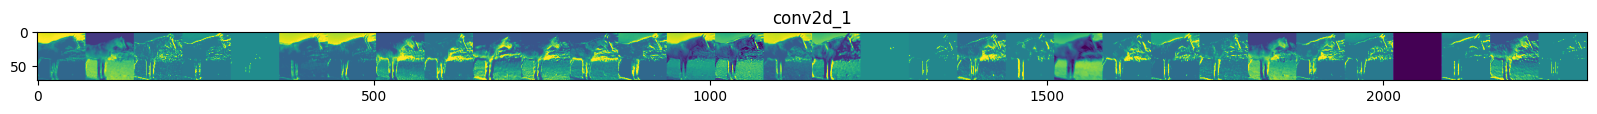

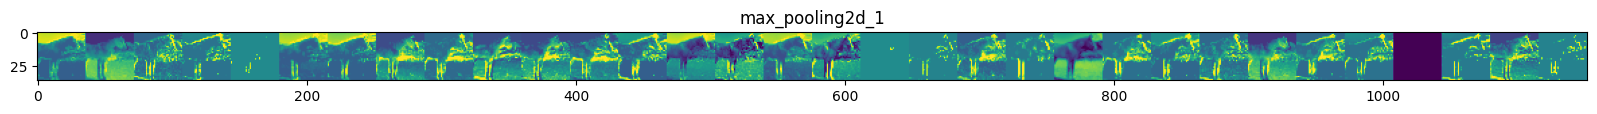

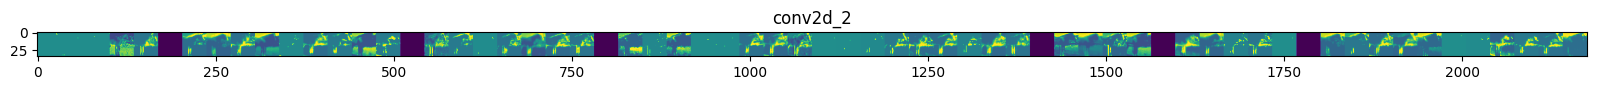

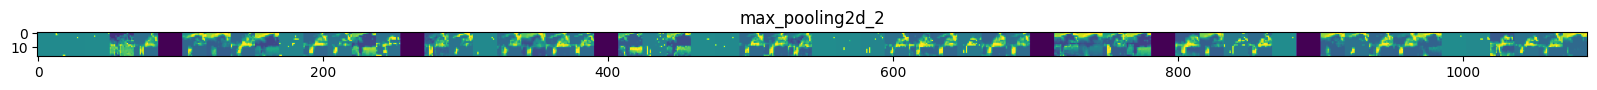

In [ ]:
%matplotlib inline

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs=model.layers[0].input, outputs=successive_outputs)

# Prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Scale by 1/255
x /= 255

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of the plot
layer_names = [layer.name for layer in model.layers[1:]]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:

    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map

    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]

    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')

      # Tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x

    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
